This script examines overall enrichment metrics, including enrichment of 9mers in overlapping 15mers. 
Generates Venn diagrams and summary tables.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np
from itertools import compress
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

In [2]:
data = pd.read_csv('../twist_covid_filtered+normalized_counts.csv').fillna(0)
data.drop(columns='Unnamed: 0',inplace=True)
data.drop(columns='Unnamed: 0.1',inplace=True)
data=data[data['doped_match']!='match'] #keep only covid peptides


/Users/brooke/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,40,42,43,47,51,55,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Includes calculation for edge peptides 

def combine_15mers_9mers(uniprot, prot_dict, mhc, data):
    #########
    # Combines dataframe of yeast display 15mer peptide information with an ordered 15mer list of peptides 
    # from protein (defined by 'uniprot' in 'prot_dict'). Then calls hits for given 'mhc' and determines which 9mer 
    # in that 15mer is best.
    #########
    # data = daframe of 15mers and yeast display enrichment information
    # length = length of peptides in library
    # uniprot = uniprot name so can find protein in prot_dict
    # prot_dict = contains protein sequences in a dictionary; keys are protein names (encoded by variable "uniprot")
    # mhc = HLA-DR401/402/404 (401, 402, 404) to use for defining if enrichment
    #########
    
    #For each uniprot protein, extract nmers
    mers = []
    order = []
    source=[]
    length = 15
    seq = prot_dict[uniprot].seq
    for i in range(0,len(seq)-(length-1)):
        mers.append(str(seq[i:i+length]))
        order.append(i+1)
        source.append(uniprot)
    df = pd.DataFrame({'{}mers'.format(length):mers, 'order':order,'source':source})

    # Merge list in order with dataset 
    merged = pd.merge(left=df, right=data,left_on='{}mers'.format(length),right_on='name',how='inner')

    #Keep hits above thresholds - indicate hits
    #######
    #hit using undoped
    merged['hit u'] = merged['frac_ undoped-{} post-R2 - positive '.format(mhc)]>merged['frac_ undoped-{} post-R1 - positive '.format(mhc)] 

    #hit using doped
    merged['hit d'] = (merged['count_ doped-{} post-R3 '.format(mhc)]>=10)

    #hit using undoped and doped
    merged['hit d+u'] = (merged['hit d']&merged['hit u'])
    #########
    
    merged.set_index('order',inplace=True) ##important to make .loc work as wanted
        
    # Find best 9mers and their scores for each 15mer
    merged['best 9mers - hit d+u']='' #best 9mer(s) in 15mer
    merged['best 9mers - hit d+u score']= 0 #number of (consecutive) peptides containing that best 9mer(s)

    for target in range(min(merged.index),max(merged.index)+1): #15mer investigating - iterate through all    
        all_scores = []
        all_9mers = []

        for i in range (1,8):
            #For each 15mer peptide, now examine the 7 different 9mers within it.
            #Goes through the 7 adjacent peptides containing the 1st 9mer, then the 2nd, etc.
            surrounding=(merged.index>=target-7+i) & (merged.index<target+i)

            #all_scores and all_9mers are 7 member lists, one entry for each 9mer in the 15mer
            all_scores.append( np.sum(merged[surrounding]['hit d+u']) ) #score for each 9mer in 15mer peptide
            all_9mers.append(merged.loc[target, '15mers'][i-1:i+8]) #9mer being examined
            
        maxes = all_scores==max(all_scores) #boolean of if that 9mer is top (or tied top)

        # keep only the scores and 9mers corresponding to max-scoring 9mers:
        top_scores = list(compress(all_scores, maxes))
        top_9mers = list(compress(all_9mers, maxes))    

        if max(all_scores) != 0:
            top_9mers_str=''
            top_9mers_str = ' '.join(map(str, top_9mers)) 
            merged.loc[target,'best 9mers - hit d+u']= top_9mers_str
            merged.loc[target,'best 9mers - hit d+u score']= top_scores[0] #all are same, so only give value once  
            
    return merged
    


In [4]:
def do_it(mhc):
    ## SARS-CoV-1 ###
    prot_dict = SeqIO.to_dict(SeqIO.parse('../../uniprot-proteome_UP000000354 SARS-CoV-1.fasta', "fasta"))

    #spike
    uniprot = 'sp|P59594|SPIKE_CVHSA'
    merged_all = combine_15mers_9mers(uniprot, prot_dict, mhc, data)

    #nucleocapsid
    uniprot = 'sp|P59595|NCAP_CVHSA'
    merged = combine_15mers_9mers(uniprot, prot_dict, mhc, data)

    merged_all = merged_all.append(merged)
    
    ## SARS-CoV-2 ##
    prot_dict = SeqIO.to_dict(SeqIO.parse('../../nCov.fasta', "fasta"))

    for uniprot in prot_dict.keys(): #goes through all proteome proteins
        print(uniprot)    
        merged = combine_15mers_9mers(uniprot, prot_dict, mhc, data)
        merged_all = merged_all.append(merged)
        
    return merged_all

In [5]:
merged_all_401 = do_it('401')

sp|P0DTD1|R1AB_WCPV
sp|P0DTC1|R1A_WCPV
sp|P0DTC2|SPIKE_WCPV
sp|P0DTC3|AP3A_WCPV
sp|P0DTC4|VEMP_WCPV
sp|P0DTC5|VME1_WCPV
sp|P0DTC6|NS6_WCPV
sp|P0DTC7|NS7A_WCPV
sp|P0DTD8|NS7B_WCPV
sp|P0DTC8|NS8_WCPV
sp|P0DTC9|NCAP_WCPV
tr|A0A663DJA2|A0A663DJA2_9BETC
sp|P0DTD2|ORF9B_WCPV
sp|P0DTD3|Y14_WCPV


In [6]:
merged_all_402 = do_it('402')

sp|P0DTD1|R1AB_WCPV
sp|P0DTC1|R1A_WCPV
sp|P0DTC2|SPIKE_WCPV
sp|P0DTC3|AP3A_WCPV
sp|P0DTC4|VEMP_WCPV
sp|P0DTC5|VME1_WCPV
sp|P0DTC6|NS6_WCPV
sp|P0DTC7|NS7A_WCPV
sp|P0DTD8|NS7B_WCPV
sp|P0DTC8|NS8_WCPV
sp|P0DTC9|NCAP_WCPV
tr|A0A663DJA2|A0A663DJA2_9BETC
sp|P0DTD2|ORF9B_WCPV
sp|P0DTD3|Y14_WCPV


In [7]:
merged_all_404 = do_it('404')

sp|P0DTD1|R1AB_WCPV
sp|P0DTC1|R1A_WCPV
sp|P0DTC2|SPIKE_WCPV
sp|P0DTC3|AP3A_WCPV
sp|P0DTC4|VEMP_WCPV
sp|P0DTC5|VME1_WCPV
sp|P0DTC6|NS6_WCPV
sp|P0DTC7|NS7A_WCPV
sp|P0DTD8|NS7B_WCPV
sp|P0DTC8|NS8_WCPV
sp|P0DTC9|NCAP_WCPV
tr|A0A663DJA2|A0A663DJA2_9BETC
sp|P0DTD2|ORF9B_WCPV
sp|P0DTD3|Y14_WCPV


In [8]:
merged_all_401.to_csv('merged_all_15+9mers_401.csv')
merged_all_402.to_csv('merged_all_15+9mers_402.csv')
merged_all_404.to_csv('merged_all_15+9mers_404.csv')

In [9]:
print(merged_all_401[merged_all_401['hit d+u']==True]['15mers'].nunique())
print(merged_all_402[merged_all_402['hit d+u']==True]['15mers'].nunique())
print(merged_all_404[merged_all_404['hit d+u']==True]['15mers'].nunique())

#2467
#1690
#2094

2467
1690
2094


# Make venn diagrams of peptides 

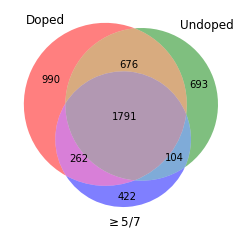

990 693 676 422 262 104 1791


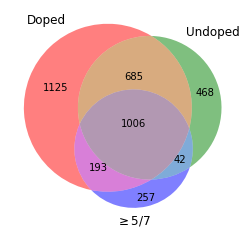

1125 468 685 257 193 42 1006


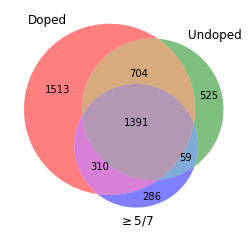

1513 525 704 286 310 59 1391


In [10]:
def count_fn(df):
    return len(np.unique(df['15mers']))


def venn_diagram(merged_all):
    # 1xx = hit in doped
    cond_1xx = (merged_all['hit d']==True)

    # x1x = hit in undoped
    cond_x1x = (merged_all['hit u']==True)

    # xx1 = >=5/7 are hits
    cond_xx1 = (merged_all['best 9mers - hit d+u score']>=5)

    #nXXX indicates where in venn diagram this value falls 
    ## {https://en.wikipedia.org/wiki/Venn_diagram#/media/File:Venn3tab.svg}

    n100 = count_fn(merged_all[  cond_1xx & ~cond_x1x & ~cond_xx1]) 
    n010 = count_fn(merged_all[ ~cond_1xx &  cond_x1x & ~cond_xx1]) 
    n001 = count_fn(merged_all[ ~cond_1xx & ~cond_x1x &  cond_xx1]) 

    n110 = count_fn(merged_all[  cond_1xx &  cond_x1x & ~cond_xx1]) 
    n011 = count_fn(merged_all[ ~cond_1xx &  cond_x1x &  cond_xx1]) 
    n101 = count_fn(merged_all[  cond_1xx & ~cond_x1x &  cond_xx1]) 

    n111 = count_fn(merged_all[  cond_1xx &  cond_x1x &  cond_xx1]) 

    venn3(subsets = (n100, n010, n110, n001, n101, n011, n111), set_labels = ('Doped', 'Undoped', r'$\geq 5/7$'), alpha = 0.5)
    plt.show()
    
    print(n100, n010, n110, n001, n101, n011, n111)

    return None

venn_diagram(merged_all_401)
venn_diagram(merged_all_402)
venn_diagram(merged_all_404)

# Make figures comparing two groups at a time:

In [11]:
merged_all = merged_all_401

In [12]:
#make separate figures for doped/undoped; then enriched/N of seven

# 1xx = hit in doped
cond_1xx = (merged_all['hit d']==True)

# x1x = hit in undoped
cond_x1x = (merged_all['hit u']==True)

# xx1 = >=5/7 are hits
cond_xx1 = (merged_all['best 9mers - hit d+u score']>=5)

# 11x = hit in doped and undoped 
cond_11x = (merged_all['hit d']==True)&(merged_all['hit u']==True)

#nXXX indicates where in venn diagram this value falls 
## {https://en.wikipedia.org/wiki/Venn_diagram#/media/File:Venn3tab.svg}

#just doped vs undoped
n10 = count_fn(merged_all[  cond_1xx & ~cond_x1x]) 
n01 = count_fn(merged_all[ ~cond_1xx &  cond_x1x]) 
n11 = count_fn(merged_all[  cond_1xx &  cond_x1x]) 

#enriched in doped and undoped vs N/7 ("m")
m10 = count_fn(merged_all[  cond_11x & ~cond_xx1]) #enriched, no N/7
m11 = count_fn(merged_all[  cond_11x &  cond_xx1]) #enriched, yes N/7
m01 = count_fn(merged_all[ ~cond_11x &  cond_xx1]) #no enriched, yes N/7


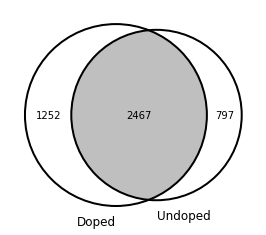

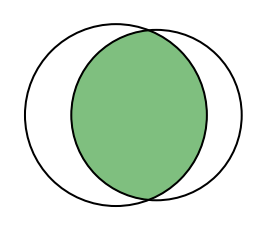

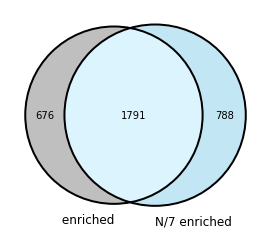

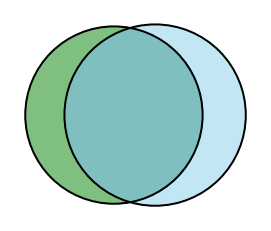

In [13]:
#(doped) vs (undoped) enriched
v=venn2(subsets = (n10, n01, n11), set_labels = ('Doped', 'Undoped'), alpha = 0.5,set_colors=('white','white','white'))
v.get_patch_by_id('11').set_color('gray')
venn2_circles(subsets = (n10, n01, n11))
plt.show()

#remove labels
v=venn2(subsets = (n10, n01, n11), set_labels = ('', ''), alpha = 0.5,set_colors=('white','white','white'))
v.get_patch_by_id('11').set_color('green')
venn2_circles(subsets = (n10, n01, n11))
for i in ['01','10','11']:
    v.get_label_by_id(i).set_text("")
plt.show()


#############
#(doped and undoped enriched) vs (>=5/7 enriched)
v=venn2(subsets = (m10, m01, m11), set_labels = (' enriched', 'N/7 enriched'), alpha = 0.5,set_colors=('grey','skyblue'))
venn2_circles(subsets = (m10, m01, m11))
plt.show()

#Remove labels - change colors
v=venn2(subsets = (m10, m01, m11), set_labels = ('', ''), alpha = 0.5,set_colors=('green','skyblue'))
venn2_circles(subsets = (m10, m01, m11))
v.get_patch_by_id('11').set_color('teal')
for i in ['01','10','11']:
    v.get_label_by_id(i).set_text("")
plt.show()



# Generate number of peptides enriched in each protein

In [14]:
#merge dataset with P1 dataset so can see how many unique 9mers also enriched

col_list = ['protein','MHC','N unique 15mers enriched','N unique 9mers enriched (pred cores; native)','N unique 15mers enriched (containing 9mer >=5/7 enriched)']
hits_table =[]

for mhc in ['401','402','404']:
    #401,402,404: Cluster0=P1 start - use cluster0-6 for 'not in linker'
    cores = pd.read_csv('test-v4_{}_twist_covid_filtered+normalized_counts_d+u.csv'.format(mhc))
    cores['native'] = cores['P1']<=6
    cores['9mer native part']=cores.apply(lambda cores: cores['sequence'][cores['P1']:cores['P1']+9], axis=1)
    print(cores)

    if mhc=='401':
        df = pd.merge(left=merged_all_401, right=cores, left_on='name',right_on='sequence',how='left') #merge so captures 'P1'
    elif mhc=='402':
        df = pd.merge(left=merged_all_402, right=cores, left_on='name',right_on='sequence',how='left') #merge so captures 'P1'
    elif mhc=='404':
        df = pd.merge(left=merged_all_404, right=cores, left_on='name',right_on='sequence',how='left') #merge so captures 'P1'
    
    df.drop(columns=['sequence','count'],inplace=True)
    display(df)

    for uniprot in list(np.unique(df['source'])):
        n_15mer=len(np.unique(df[(df['hit d+u']==True)&(df['source']==uniprot)]['15mers']))
        n_9mer =len(np.unique(df[(df['native' ]==True)&(df['source']==uniprot)]['9mer native part']))
        n_15mer_nof7 = len(np.unique(df[(df['hit d+u']==True)&(df['source']==uniprot)&(df['best 9mers - hit d+u score']>=5)]['15mers']))
        
        hits_table.append([uniprot,mhc, n_15mer, n_9mer,n_15mer_nof7])

    hits_table_df = pd.DataFrame(hits_table, columns = col_list)
display(hits_table_df)

hits_table_df.to_csv('summary_enriched_15+9mers_v2-check.csv') #"v2-check" to compare with v2 in paper
    

             sequence  count  P1  native 9mer native part
0     KDGTCGLVEVEKGVL      1   7   False         VEVEKGVL
1     LEGIQYGRSGETLGV      1   5    True        YGRSGETLG
2     QYGRSGETLGVLVPH      1   1    True        YGRSGETLG
3     KHSSGVTRELMRELN      1   9   False           LMRELN
4     HSSGVTRELMRELNG      1   8   False          LMRELNG
5     SSGVTRELMRELNGG      1   7   False         LMRELNGG
6     SGVTRELMRELNGGA      1   6    True        LMRELNGGA
7     GVTRELMRELNGGAY      1   5    True        LMRELNGGA
8     TRELMRELNGGAYTR      1   3    True        LMRELNGGA
9     RELMRELNGGAYTRY      1   2    True        LMRELNGGA
10    ELMRELNGGAYTRYV      1   1    True        LMRELNGGA
11    RELNGGAYTRYVDNN      1   7   False         YTRYVDNN
12    LNGGAYTRYVDNNFC      1   5    True        YTRYVDNNF
13    NGGAYTRYVDNNFCG      1   4    True        YTRYVDNNF
14    GAYTRYVDNNFCGPD      1   2    True        YTRYVDNNF
15    DGYPLECIKDLLARA      1   4    True        LECIKDLLA
16    SEQLDFID

,15mers,source,name,dna,count_ doped-401 R0 (doped),count_ doped-402 R0 (doped),count_ doped-404 R0 (doped),count_ doped-401 post-R1,count_ doped-402 post-R1,count_ doped-404 post-R1,...,frac_ undoped-402 post-R3 - negative,frac_ undoped-404 post-R3 - negative,hit u,hit d,hit d+u,best 9mers - hit d+u,best 9mers - hit d+u score,P1,native,9mer native part
0,MFIFLLFLTLTSGSD,sp|P59594|SPIKE_CVHSA,MFIFLLFLTLTSGSD,ATGTTTATTTTCCTCCTGTTCTTAACATTAACAAGTGGCTCTGAT,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,False,False,False,,0,NaN,NaN,NaN
1,FIFLLFLTLTSGSDL,sp|P59594|SPIKE_CVHSA,FIFLLFLTLTSGSDL,TTCATTTTTTTATTATTTCTTACCCTTACCTCTGGGTCCGATTTA,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000011,True,False,False,,0,NaN,NaN,NaN
2,IFLLFLTLTSGSDLD,sp|P59594|SPIKE_CVHSA,IFLLFLTLTSGSDLD,ATTTTCCTATTGTTCCTGACATTGACTAGTGGCTCGGATCTAGAC,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,False,False,False,,0,NaN,NaN,NaN
3,FLLFLTLTSGSDLDR,sp|P59594|SPIKE_CVHSA,FLLFLTLTSGSDLDR,TTCTTACTTTTTTTGACATTAACCTCCGGATCCGACCTTGATAGA,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,False,False,False,,0,NaN,NaN,NaN
4,LLFLTLTSGSDLDRC,sp|P59594|SPIKE_CVHSA,LLFLTLTSGSDLDRC,TTACTTTTCTTAACACTCACGTCAGGAAGTGATCTTGACAGATGC,0.0,0.0,0.0,8.0,12.0,6.0,...,0.000022,0.000000,False,False,False,,0,NaN,NaN,NaN
5,LFLTLTSGSDLDRCT,sp|P59594|SPIKE_CVHSA,LFLTLTSGSDLDRCT,CTTTTCCTGACTTTAACATCCGGCAGTGATCTTGACAGATGTACG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000007,0.000000,False,False,False,,0,NaN,NaN,NaN
6,FLTLTSGSDLDRCTT,sp|P59594|SPIKE_CVHSA,FLTLTSGSDLDRCTT,TTTCTAACACTCACGTCTGGCTCGGATCTGGATAGGTGTACAACT,0.0,0.0,0.0,3.0,0.0,6.0,...,0.000000,0.000000,False,False,False,,0,NaN,NaN,NaN
7,LTLTSGSDLDRCTTF,sp|P59594|SPIKE_CVHSA,LTLTSGSDLDRCTTF,TTAACGTTAACATCTGGTTCTGATTTAGATAGATGCACGACATTT,1.0,0.0,0.0,20.0,43.0,45.0,...,0.000612,0.000337,False,True,False,,0,NaN,NaN,NaN
8,TLTSGSDLDRCTTFD,sp|P59594|SPIKE_CVHSA,TLTSGSDLDRCTTFD,ACACTCACCTCCGGATCAGATCTAGACAGGTGTACTACATTTGAT,0.0,0.0,0.0,3.0,0.0,0.0,...,0.000014,0.000011,False,False,False,,0,NaN,NaN,NaN
9,LTSGSDLDRCTTFDD,sp|P59594|SPIKE_CVHSA,LTSGSDLDRCTTFDD,TTGACAAGTGGTTCAGATCTGGATAGATGTACTACCTTTGATGAT,0.0,0.0,0.0,7.0,5.0,7.0,...,0.000043,0.000021,False,True,False,,0,NaN,NaN,NaN


             sequence  count  P1  native 9mer native part
0     HVQLSLPVLQVRDVL      1   7   False         VLQVRDVL
1     VQLSLPVLQVRDVLV      1   6    True        VLQVRDVLV
2     QLSLPVLQVRDVLVR      1   5    True        VLQVRDVLV
3     LSLPVLQVRDVLVRG      1   4    True        VLQVRDVLV
4     SLPVLQVRDVLVRGF      1   3    True        VLQVRDVLV
5     LPVLQVRDVLVRGFG      1   2    True        VLQVRDVLV
6     PQLEQPYVFIKRSDA      1   9   False           IKRSDA
7     LEQPYVFIKRSDART      1   6    True        FIKRSDART
8     SGETLGVLVPHVGEI      1   3    True        TLGVLVPHV
9     GVLVPHVGEIPVAYR      1   6    True        VGEIPVAYR
10    PHVGEIPVAYRKVLL      1   7   False         VAYRKVLL
11    GVTRELMRELNGGAY      1   9   False           LNGGAY
12    TRELMRELNGGAYTR      1   7   False         LNGGAYTR
13    RELMRELNGGAYTRY      1   6    True        LNGGAYTRY
14    ELMRELNGGAYTRYV      1   5    True        LNGGAYTRY
15    GPDGYPLECIKDLLA      1   6    True        LECIKDLLA
16    PDGYPLEC

,15mers,source,name,dna,count_ doped-401 R0 (doped),count_ doped-402 R0 (doped),count_ doped-404 R0 (doped),count_ doped-401 post-R1,count_ doped-402 post-R1,count_ doped-404 post-R1,...,frac_ undoped-402 post-R3 - negative,frac_ undoped-404 post-R3 - negative,hit u,hit d,hit d+u,best 9mers - hit d+u,best 9mers - hit d+u score,P1,native,9mer native part
0,MFIFLLFLTLTSGSD,sp|P59594|SPIKE_CVHSA,MFIFLLFLTLTSGSD,ATGTTTATTTTCCTCCTGTTCTTAACATTAACAAGTGGCTCTGAT,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,False,False,False,,0,NaN,NaN,NaN
1,FIFLLFLTLTSGSDL,sp|P59594|SPIKE_CVHSA,FIFLLFLTLTSGSDL,TTCATTTTTTTATTATTTCTTACCCTTACCTCTGGGTCCGATTTA,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000011,False,False,False,LTLTSGSDL,1,NaN,NaN,NaN
2,IFLLFLTLTSGSDLD,sp|P59594|SPIKE_CVHSA,IFLLFLTLTSGSDLD,ATTTTCCTATTGTTCCTGACATTGACTAGTGGCTCGGATCTAGAC,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,False,False,False,LTLTSGSDL TLTSGSDLD,1,NaN,NaN,NaN
3,FLLFLTLTSGSDLDR,sp|P59594|SPIKE_CVHSA,FLLFLTLTSGSDLDR,TTCTTACTTTTTTTGACATTAACCTCCGGATCCGACCTTGATAGA,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,False,False,False,LTLTSGSDL TLTSGSDLD LTSGSDLDR,1,NaN,NaN,NaN
4,LLFLTLTSGSDLDRC,sp|P59594|SPIKE_CVHSA,LLFLTLTSGSDLDRC,TTACTTTTCTTAACACTCACGTCAGGAAGTGATCTTGACAGATGC,0.0,0.0,0.0,8.0,12.0,6.0,...,0.000022,0.000000,False,False,False,LTLTSGSDL TLTSGSDLD LTSGSDLDR TSGSDLDRC,1,NaN,NaN,NaN
5,LFLTLTSGSDLDRCT,sp|P59594|SPIKE_CVHSA,LFLTLTSGSDLDRCT,CTTTTCCTGACTTTAACATCCGGCAGTGATCTTGACAGATGTACG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000007,0.000000,False,False,False,LTLTSGSDL TLTSGSDLD LTSGSDLDR TSGSDLDRC SGSDLDRCT,1,NaN,NaN,NaN
6,FLTLTSGSDLDRCTT,sp|P59594|SPIKE_CVHSA,FLTLTSGSDLDRCTT,TTTCTAACACTCACGTCTGGCTCGGATCTGGATAGGTGTACAACT,0.0,0.0,0.0,3.0,0.0,6.0,...,0.000000,0.000000,False,False,False,LTLTSGSDL TLTSGSDLD LTSGSDLDR TSGSDLDRC SGSDLD...,1,NaN,NaN,NaN
7,LTLTSGSDLDRCTTF,sp|P59594|SPIKE_CVHSA,LTLTSGSDLDRCTTF,TTAACGTTAACATCTGGTTCTGATTTAGATAGATGCACGACATTT,1.0,0.0,0.0,20.0,43.0,45.0,...,0.000612,0.000337,True,True,True,LTLTSGSDL TLTSGSDLD LTSGSDLDR TSGSDLDRC SGSDLD...,1,2.0,True,LTSGSDLDR
8,TLTSGSDLDRCTTFD,sp|P59594|SPIKE_CVHSA,TLTSGSDLDRCTTFD,ACACTCACCTCCGGATCAGATCTAGACAGGTGTACTACATTTGAT,0.0,0.0,0.0,3.0,0.0,0.0,...,0.000014,0.000011,False,False,False,TLTSGSDLD LTSGSDLDR TSGSDLDRC SGSDLDRCT GSDLDR...,1,NaN,NaN,NaN
9,LTSGSDLDRCTTFDD,sp|P59594|SPIKE_CVHSA,LTSGSDLDRCTTFDD,TTGACAAGTGGTTCAGATCTGGATAGATGTACTACCTTTGATGAT,0.0,0.0,0.0,7.0,5.0,7.0,...,0.000043,0.000021,False,False,False,LTSGSDLDR TSGSDLDRC SGSDLDRCT GSDLDRCTT SDLDRCTTF,1,NaN,NaN,NaN


             sequence  count  P1  native 9mer native part
0     THVQLSLPVLQVRDV      1   2    True        VQLSLPVLQ
1     HVQLSLPVLQVRDVL      1   1    True        VQLSLPVLQ
2     QLSLPVLQVRDVLVR      1   5    True        VLQVRDVLV
3     LSLPVLQVRDVLVRG      1   4    True        VLQVRDVLV
4     LPVLQVRDVLVRGFG      1   2    True        VLQVRDVLV
5     LQVRDVLVRGFGDSV      1   7   False         VRGFGDSV
6     DGTCGLVEVEKGVLP      1   8   False          VEKGVLP
7     GTCGLVEVEKGVLPQ      1   8   False          EKGVLPQ
8     RTAPHGHVMVELVAE      1   7   False         VMVELVAE
9     TAPHGHVMVELVAEL      1  10   False            LVAEL
10    KHSSGVTRELMRELN      1   9   False           LMRELN
11    HSSGVTRELMRELNG      1   8   False          LMRELNG
12    SGVTRELMRELNGGA      1   6    True        LMRELNGGA
13    GVTRELMRELNGGAY      1   5    True        LMRELNGGA
14    TRELMRELNGGAYTR      1   3    True        LMRELNGGA
15    RELMRELNGGAYTRY      1   2    True        LMRELNGGA
16    ELMRELNG

,15mers,source,name,dna,count_ doped-401 R0 (doped),count_ doped-402 R0 (doped),count_ doped-404 R0 (doped),count_ doped-401 post-R1,count_ doped-402 post-R1,count_ doped-404 post-R1,...,frac_ undoped-402 post-R3 - negative,frac_ undoped-404 post-R3 - negative,hit u,hit d,hit d+u,best 9mers - hit d+u,best 9mers - hit d+u score,P1,native,9mer native part
0,MFIFLLFLTLTSGSD,sp|P59594|SPIKE_CVHSA,MFIFLLFLTLTSGSD,ATGTTTATTTTCCTCCTGTTCTTAACATTAACAAGTGGCTCTGAT,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,False,False,False,,0,NaN,NaN,NaN
1,FIFLLFLTLTSGSDL,sp|P59594|SPIKE_CVHSA,FIFLLFLTLTSGSDL,TTCATTTTTTTATTATTTCTTACCCTTACCTCTGGGTCCGATTTA,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000011,True,False,False,LTLTSGSDL,1,NaN,NaN,NaN
2,IFLLFLTLTSGSDLD,sp|P59594|SPIKE_CVHSA,IFLLFLTLTSGSDLD,ATTTTCCTATTGTTCCTGACATTGACTAGTGGCTCGGATCTAGAC,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,False,False,False,LTLTSGSDL TLTSGSDLD,1,NaN,NaN,NaN
3,FLLFLTLTSGSDLDR,sp|P59594|SPIKE_CVHSA,FLLFLTLTSGSDLDR,TTCTTACTTTTTTTGACATTAACCTCCGGATCCGACCTTGATAGA,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,False,False,False,LTLTSGSDL TLTSGSDLD LTSGSDLDR,1,NaN,NaN,NaN
4,LLFLTLTSGSDLDRC,sp|P59594|SPIKE_CVHSA,LLFLTLTSGSDLDRC,TTACTTTTCTTAACACTCACGTCAGGAAGTGATCTTGACAGATGC,0.0,0.0,0.0,8.0,12.0,6.0,...,0.000022,0.000000,False,False,False,TSGSDLDRC,2,NaN,NaN,NaN
5,LFLTLTSGSDLDRCT,sp|P59594|SPIKE_CVHSA,LFLTLTSGSDLDRCT,CTTTTCCTGACTTTAACATCCGGCAGTGATCTTGACAGATGTACG,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000007,0.000000,False,False,False,TSGSDLDRC SGSDLDRCT,2,NaN,NaN,NaN
6,FLTLTSGSDLDRCTT,sp|P59594|SPIKE_CVHSA,FLTLTSGSDLDRCTT,TTTCTAACACTCACGTCTGGCTCGGATCTGGATAGGTGTACAACT,0.0,0.0,0.0,3.0,0.0,6.0,...,0.000000,0.000000,False,True,False,TSGSDLDRC SGSDLDRCT GSDLDRCTT,2,NaN,NaN,NaN
7,LTLTSGSDLDRCTTF,sp|P59594|SPIKE_CVHSA,LTLTSGSDLDRCTTF,TTAACGTTAACATCTGGTTCTGATTTAGATAGATGCACGACATTT,1.0,0.0,0.0,20.0,43.0,45.0,...,0.000612,0.000337,True,True,True,TSGSDLDRC SGSDLDRCT GSDLDRCTT SDLDRCTTF,2,8.0,False,LDRCTTF
8,TLTSGSDLDRCTTFD,sp|P59594|SPIKE_CVHSA,TLTSGSDLDRCTTFD,ACACTCACCTCCGGATCAGATCTAGACAGGTGTACTACATTTGAT,0.0,0.0,0.0,3.0,0.0,0.0,...,0.000014,0.000011,False,False,False,TSGSDLDRC SGSDLDRCT GSDLDRCTT SDLDRCTTF DLDRCTTFD,2,NaN,NaN,NaN
9,LTSGSDLDRCTTFDD,sp|P59594|SPIKE_CVHSA,LTSGSDLDRCTTFDD,TTGACAAGTGGTTCAGATCTGGATAGATGTACTACCTTTGATGAT,0.0,0.0,0.0,7.0,5.0,7.0,...,0.000043,0.000021,False,False,False,TSGSDLDRC SGSDLDRCT GSDLDRCTT SDLDRCTTF DLDRCT...,2,NaN,NaN,NaN


,protein,MHC,N unique 15mers enriched,N unique 9mers enriched (pred cores; native),N unique 15mers enriched (containing 9mer >=5/7 enriched)
0,sp|P0DTC1|R1A_WCPV,401,948,228,658
1,sp|P0DTC2|SPIKE_WCPV,401,305,67,221
2,sp|P0DTC3|AP3A_WCPV,401,22,4,11
3,sp|P0DTC4|VEMP_WCPV,401,6,1,0
4,sp|P0DTC5|VME1_WCPV,401,40,7,29
5,sp|P0DTC6|NS6_WCPV,401,0,0,0
6,sp|P0DTC7|NS7A_WCPV,401,27,8,18
7,sp|P0DTC8|NS8_WCPV,401,41,10,32
8,sp|P0DTC9|NCAP_WCPV,401,34,8,24
9,sp|P0DTD1|R1AB_WCPV,401,1652,388,1204


In [15]:
# Print length of each protein in proteome
    
## SARS-CoV-1 ###
prot_dict = SeqIO.to_dict(SeqIO.parse('../../uniprot-proteome_UP000000354 SARS-CoV-1.fasta', "fasta"))
for uniprot in ['sp|P59594|SPIKE_CVHSA','sp|P59595|NCAP_CVHSA']:
    print(uniprot)
    seq = prot_dict[uniprot].seq
    print(len(seq))

## SARS-CoV-2 ##
prot_dict = SeqIO.to_dict(SeqIO.parse('../../nCov.fasta', "fasta"))
for uniprot in prot_dict.keys(): #goes through all proteome proteins
    print(uniprot)    
    seq = prot_dict[uniprot].seq
    print(len(seq))

sp|P59594|SPIKE_CVHSA
1255
sp|P59595|NCAP_CVHSA
422
sp|P0DTD1|R1AB_WCPV
7096
sp|P0DTC1|R1A_WCPV
4405
sp|P0DTC2|SPIKE_WCPV
1273
sp|P0DTC3|AP3A_WCPV
275
sp|P0DTC4|VEMP_WCPV
75
sp|P0DTC5|VME1_WCPV
222
sp|P0DTC6|NS6_WCPV
61
sp|P0DTC7|NS7A_WCPV
121
sp|P0DTD8|NS7B_WCPV
43
sp|P0DTC8|NS8_WCPV
121
sp|P0DTC9|NCAP_WCPV
419
tr|A0A663DJA2|A0A663DJA2_9BETC
38
sp|P0DTD2|ORF9B_WCPV
97
sp|P0DTD3|Y14_WCPV
73
